<a href="https://colab.research.google.com/github/mhowlin-web/dm2025b/blob/main/src/rpart/102_FinalTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arbol elemental con libreria  rpart

## Introduccion

Este es el primer notebook/script de la materia Laboratorio de Implementacion I, se expone en la primera clase.
<br>Se utilizan Arboles de Decision, librería **rpart**,  el primer algoritmo, el más simple que utilizaremos en la materia pero que es el fundamento de los Ensembles de Arboles de Decision tales como  Random Forest y  Gradient Boosting of Decision Trees (XGBoost/LightGBM)
<br>La materia posee un dataset con 31 meses, en las primeras clases toda la cohorte, independiente de la modalidad elegida, utilizará **dataset_pequeno** que posee apenas un mes histórico 202107 y obviamente el mes donde se debe realizar la predicción 202109
<br>Este primer notebook/script **no** desarrolla todas las etapas necesarias para la generación de un buen modelo, apenas posee la parte final del pipeline/workflow.

### Limitaciones



Este primer y elemental notebook/script supone estas simplificaciónes:
* Solo se dispone del mes 202107 con el campo clase_ternaria completo, es el unico mes donde entrenar
* Se decidió previamente, de alguna forma, que la etapa de Final Training se hará sobre TODO el dataset de 202107
* Se obtuvieron previamente los hiperparámetros optimos de la libería **rpart** para este problema, mediante algun tipo de busqueda búsqueda.  Esta es la etapa que demandará decenas de horas para quienes opten por la *modalidad Analista Senior*
* No se realiza ningun tipo de feature engineering intra-mes
* Al no disponer de datos históricos no se realiza ningun tipo de feature engineering histórico
* No hay ningun analisis de la calidad de los campos, no se analiza si ocurrió alguna catástrofe ese mes y algun campo no se calculó correctamente
* Noy hay ningun tipo de análisis de Data Drifting entre los meses de 202107 y 202109
* Obedientemente se trabaja utlizando como clase el campo **clase_ternaria** sin ningun tipo de transformacion


<br> Obviamente, a lo largo de la materia se avanzará sobre todas las limitacinoes anteriores.

## Seteo del ambiente en Google Colab

Esta parte se debe correr con el runtime en Python3
<br>Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type ->  **Python 3**

Conectar la virtual machine donde esta corriendo Google Colab con el  Google Drive, para poder tener persistencia de archivos

In [ ]:
# primero establecer el Runtime de Python 3
from google.colab import drive
drive.mount('/content/.drive')

Mounted at /content/.drive


Para correr la siguiente celda es fundamental en Arranque en Frio haber copiado el archivo **kaggle.json** al Google Drive, en la carpeta indicada en el instructivo

<br>los siguientes comando estan en shell script de Linux
*   Crear las carpetas en el Google Drive
*   "instalar" el archivo kaggle.json desde el Google Drive a la virtual machine para que pueda ser utilizado por la libreria  kaggle de Python
*   Bajar el  **dataset_pequeno**  al  Google Drive  y tambien al disco local de la virtual machine que esta corriendo Google Colab



In [ ]:
%%shell

mkdir -p "/content/.drive/My Drive/dm"
mkdir -p "/content/buckets"
ln -s "/content/.drive/My Drive/dm" /content/buckets/b1

mkdir -p ~/.kaggle
cp /content/buckets/b1/kaggle/kaggle.json  ~/.kaggle
chmod 600 ~/.kaggle/kaggle.json


mkdir -p /content/buckets/b1/exp
mkdir -p /content/buckets/b1/datasets
mkdir -p /content/datasets



archivo_origen="https://storage.googleapis.com/open-courses/itba2025-8d0a/dataset_pequeno.csv"
archivo_destino="/content/datasets/dataset_pequeno.csv"
archivo_destino_bucket="/content/buckets/b1/datasets/dataset_pequeno.csv"

if ! test -f $archivo_destino_bucket; then
  wget  $archivo_origen  -O $archivo_destino_bucket
fi


if ! test -f $archivo_destino; then
  cp  $archivo_destino_bucket  $archivo_destino
fi


## Final Train y generacion de la prediccion

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

limpio el ambiente de R

In [ ]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,819979,43.8,2592388,138.5,3240484,173.1
Vcells,1633128,12.5,161509263,1232.3,201886464,1540.3


* Instalacion de la libreria  rpart.plot  para dibujar el arbol
* invocacion de las librerias  **data.table**  **rpart** y  **rpart.plot**

In [ ]:
# cargo las librerias que necesito
require("data.table")
require("rpart")

if (!require("rpart.plot")) install.packages("rpart.plot")
require("rpart.plot")

Crear y moverse a la carpeta donde se va a trabajar

In [ ]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento <- "KA2001"
dir.create(experimento, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento ))

## Final Training

### Final Train Dataset

Es importante notar que para el entrenamiento final utilizo el mes de 202107 completo sin ningun tipo particion  train/test, aqui no hay random, aqui no hay semillas

In [ ]:
# lectura del dataset
dataset <- fread("/content/datasets/dataset_pequeno.csv")
dtrain_final <- dataset[foto_mes == 202107] # defino donde voy a entrenar

### Hyperparameters

Aqui los hiperparámetros estan hardcodeados
<br> Usted puede jugar con ellos manualmente
<br> En las siguientes clases veremos como encontrar previamente los hiperparámetros óptimos, para ser copiados aquí

In [ ]:
param_final <- list (
  "cp"= -0.5, # complejidad minima
  "minsplit"= 600, # minima cantidad de regs en un nodo para hacer el split
  "minbucket"= 10, # minima cantidad de regs en una hoja
  "maxdepth"= 8 # profundidad máxima del arbol
)

### Training

In [ ]:
# genero el modelo,  aqui se construye el arbol
# quiero predecir clase_ternaria a partir de el resto de las variables
modelo_final <- rpart(
    formula= "clase_ternaria ~ .",
    data= dtrain_final, # los datos donde voy a entrenar
    xval= 0,
    control= param_final
)


#### Impresion del modelo

Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”


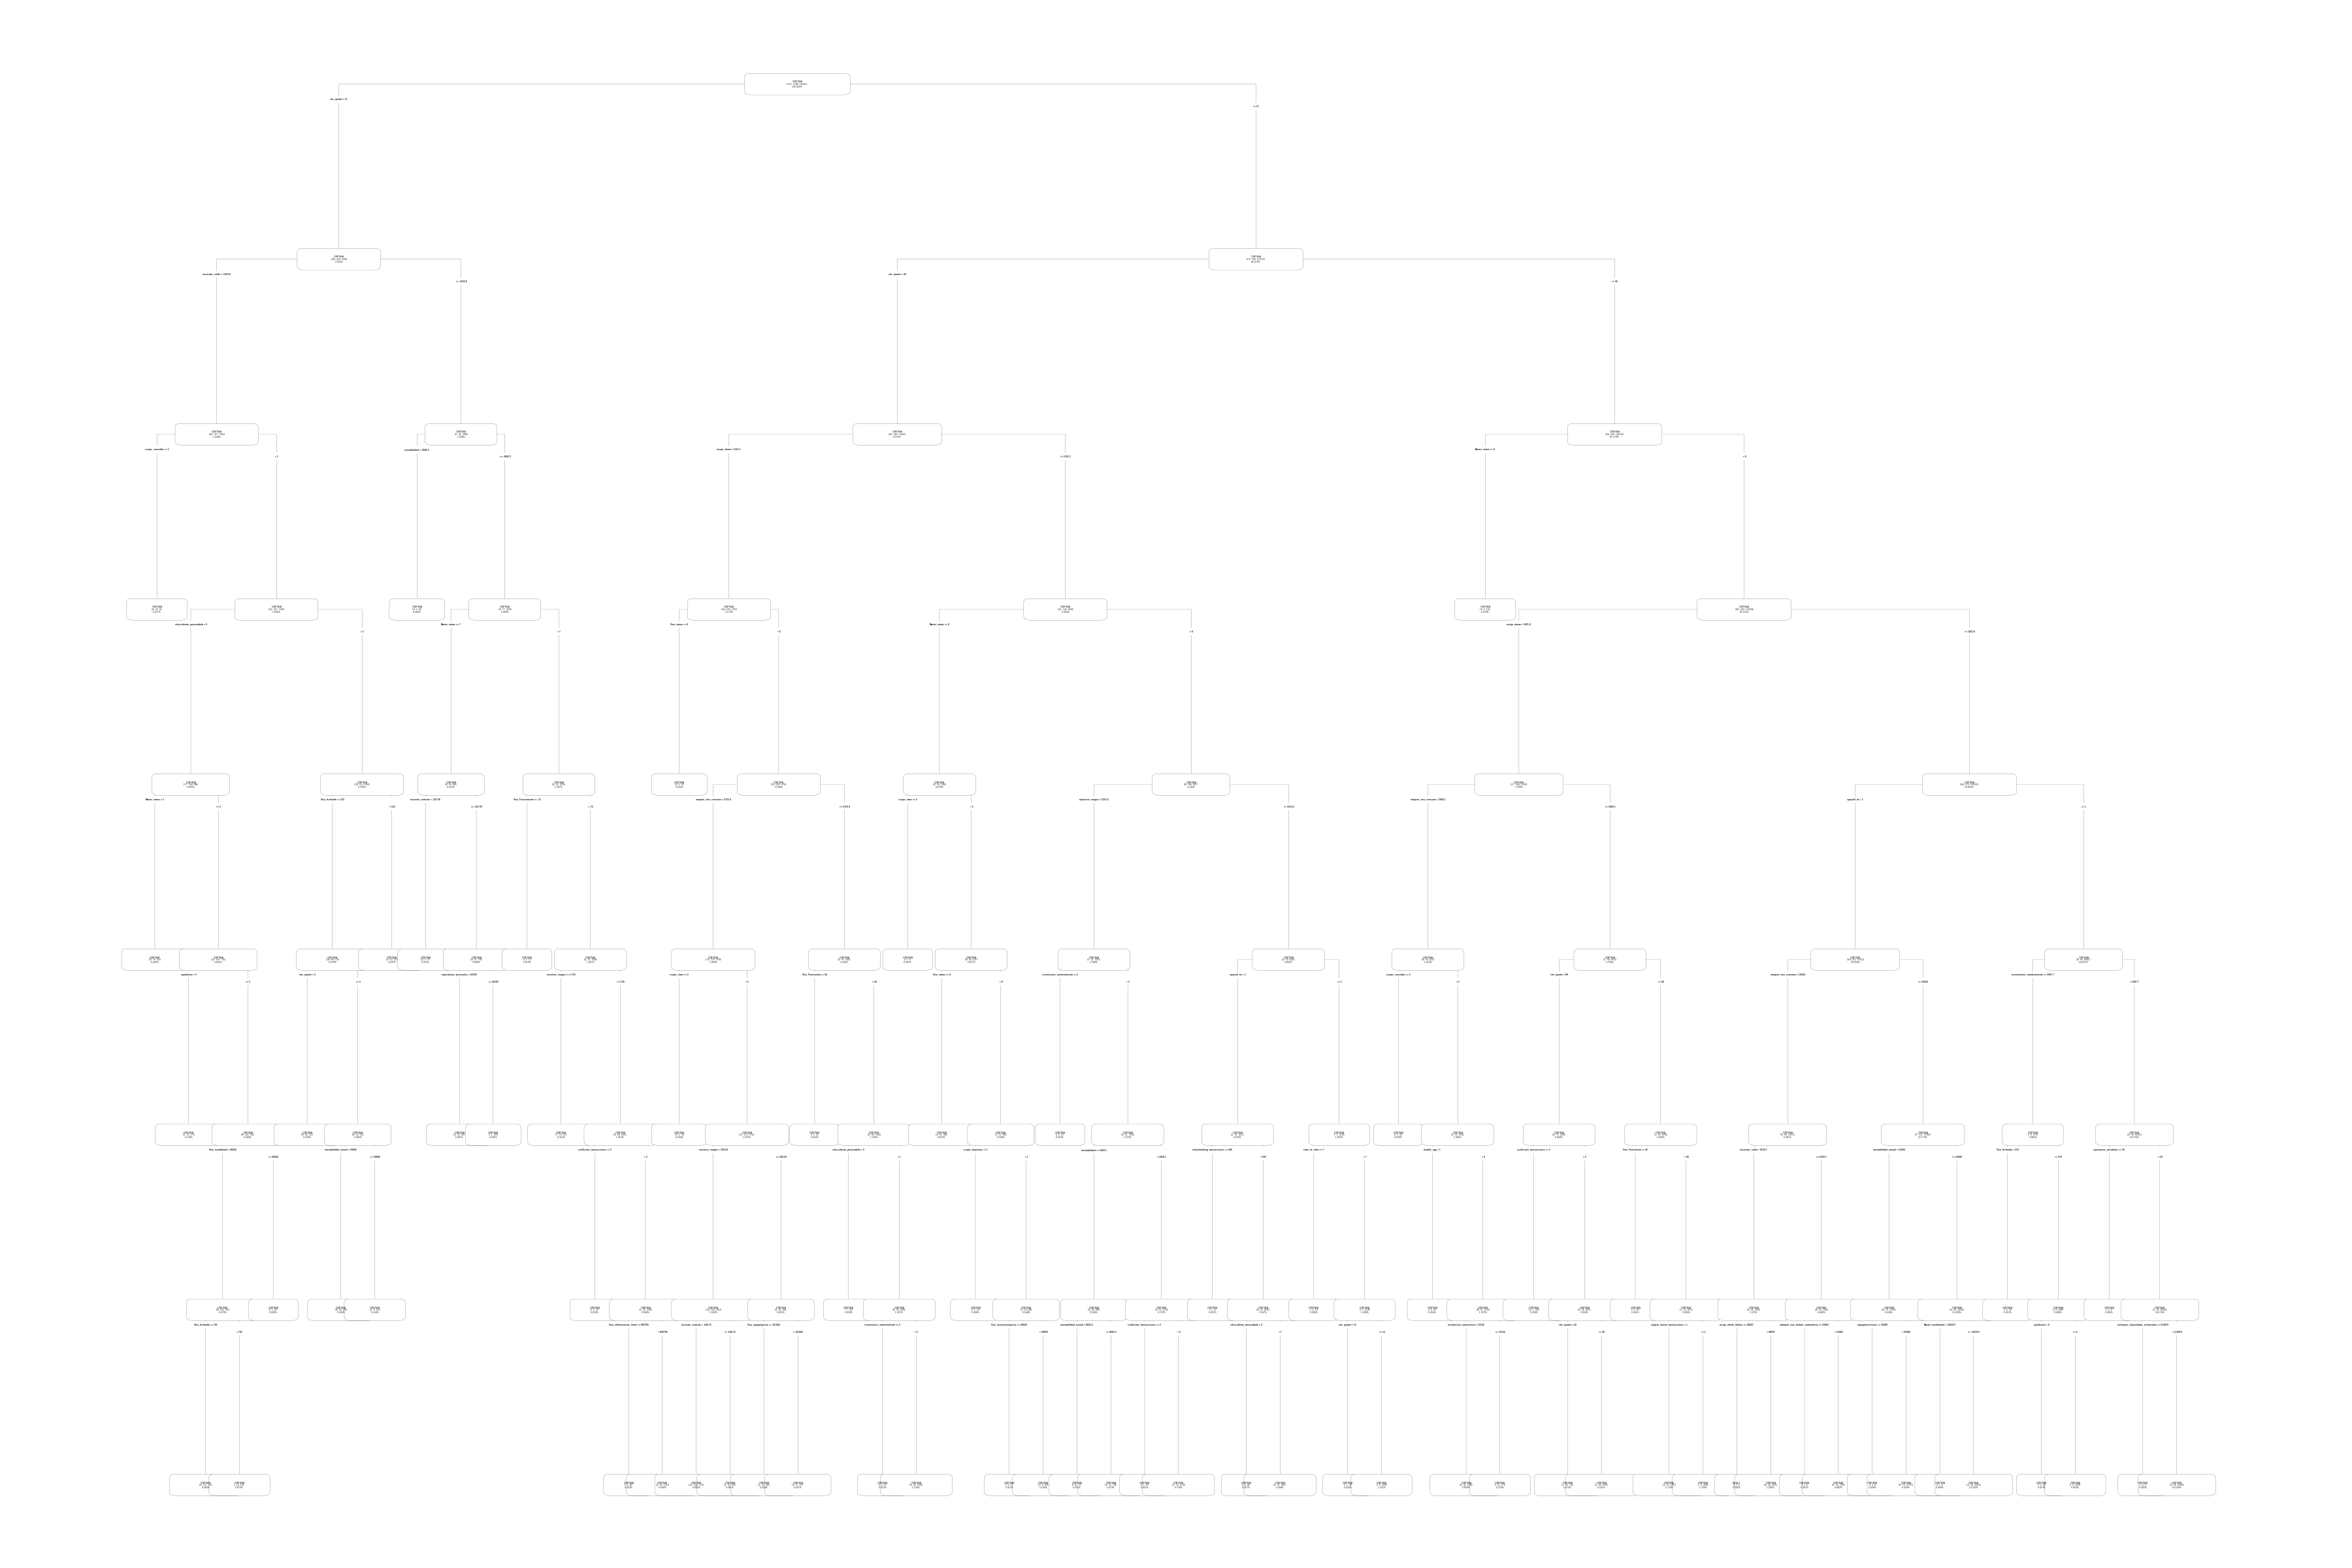

In [ ]:
# grafico el arbol
options(repr.plot.width=30, repr.plot.height=20 )

prp(modelo_final,
    extra= 101,
    digits= -5,
    branch= 1,
    type= 4,
    varlen= 0,
    faclen= 0
)

## Dataset Future

Aqui se define el dataset donde quiero hacer la prediccion final, generalmente esto viene dado por el problema y es trivial su eleccion

In [ ]:
dfuture <- dataset[foto_mes == 202109] # defino donde voy a aplicar el modelo

### Scoring

Aplico el modelo_final a los datos del futuro

In [ ]:
# aplico el modelo a los datos nuevos
prediccion <- predict(
    object= modelo_final,
    newdata= dfuture,
    type= "prob"
)

# veo que  quedó en predccion
# es una matriz, una linea por registro del dataset dfuture
# una columna para cada uno de los valores de la clase
prediccion

,BAJA+1,BAJA+2,CONTINUA
1,0.0002422246,0.0006782289,0.9990795
2,0.0002422246,0.0006782289,0.9990795
3,0.0173501577,0.0173501577,0.9652997
4,0.0007629705,0.0016531027,0.9975839
5,0.0007629705,0.0016531027,0.9975839
6,0.0002422246,0.0006782289,0.9990795
7,0.0002422246,0.0006782289,0.9990795
8,0.0007629705,0.0016531027,0.9975839
9,0.0007629705,0.0016531027,0.9975839
10,0.0035322953,0.0050461361,0.9914216


## Tabla Prediccion

In [ ]:
tb_prediccion <- as.data.table(list(
  "numero_de_cliente" = dfuture$numero_de_cliente,
  "prob"=prediccion[, "BAJA+2"]
))

## Decision

In [ ]:
# decido a quien se envia estimulo y a quien no
# como trabajo con clase_ternaria puedo hacer el corte en 1/40
# solo le envio estimulo a los registros
#  con probabilidad de BAJA+2 mayor  a  1/40

tb_prediccion[, Predicted := prob > (1/40) ]

# veo que hay en tb_prediccion
tb_prediccion

numero_de_cliente,prob,Predicted
<int>,<dbl>,<lgl>
29183733,0.0006782289,FALSE
29184468,0.0006782289,FALSE
29185245,0.0173501577,FALSE
29186441,0.0016531027,FALSE
29186475,0.0016531027,FALSE
29187730,0.0006782289,FALSE
29187764,0.0006782289,FALSE
29187961,0.0016531027,FALSE
29189899,0.0016531027,FALSE


## Kaggle

In [ ]:
# genero el archivo para Kaggle
# en el formato requerido por Kaggle
# <numero_de_cliente, Predicted>  separados por coma, estension .csv

archivo_kaggle <- "K101_001.csv"

fwrite( tb_prediccion[, list(numero_de_cliente, Predicted)],
    file = archivo_kaggle,
    sep = ","
)

### Kaggle Competition Submit

Google Colab ya trae instalada una libreria llamada **kaggle** de python, que permite hacer submits a la Plataforma Kaggle

In [ ]:
comando <- "kaggle competitions submit"
competencia <- "-c data-mining-analista-sr-2025-b"
arch <- paste( "-f", archivo_kaggle)

In [ ]:
mensaje <-  paste0( "-m 'cp=", param_final$cp, "  minsplit=", param_final$minsplit, "  minbucket=", param_final$minbucket, "  maxdepth=", param_final$maxdepth, "'")

In [ ]:
linea <- paste( comando, competencia, arch, mensaje)

# este el el comando que correria desde el prompt de Linux
linea

[1] "kaggle competitions submit -c data-mining-analista-sr-2025-b -f K101_001.csv -m 'cp=-0.5  minsplit=600  minbucket=10  maxdepth=8'"

In [ ]:
# ejecuto el comando
salida <- system(linea, intern=TRUE)
cat(salida)

Successfully submitted to Data Mining, Analista Sr 2025 B

## Tarea para el Hogar

Explorar manualmente que hiperparámetros genera una mayor ganancia en Kaggle
<br> Si en un momento logra quedar en primera posición del Private Leaderboard, saquese una selfie